In [1]:
!pip install emoji
!pip install stop-words
!pip install transformers datasets imblearn seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import emoji
import string
from nltk.corpus import stopwords
from stop_words import get_stop_words
import nltk
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/datnlp/final_full_data_main.csv')
df

,text,label
0,মেয়েরা উদ্দেশ্য অনুসারে বোবা বোবা আচরণ সুন্দর,1.0
1,গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা সত্যিই পছন্দ করি।...,1.0
2,বাহ ... পাচ্ছি সত্যিই দোষী দোষী সাব্যস্তনোটপ্রেসড,1.0
3,"হাহ, মজার বিষয়।আনোয়েড গ্রুআপ",1.0
4,থান্ডার 830 জেগে উঠলে ভালবাসুন,1.0
...,...,...
8210,बॉलिवुड़ फिल्में देखो। चाहते मुझे रेडिट मैंसेज...,0.0
8211,इनमें बहन भेजा वो पूछेगी कहीं मेरी तबियत खराब,0.0
8212,"“नही, अब बात आ गई क्या मुझे थोड़े रूपये मिल है?""",0.0
8213,**अन्तरजाल स्रोतों** वाचन हिन्दी साहित्य हर दौ...,0.0


In [4]:
label_counts = df['label'].value_counts()
print("Count of tweets with label 1.0 (sarcastic):", label_counts[1.0])
print("Count of tweets with label 0.0 (non-sarcastic):", label_counts[0.0])

Count of tweets with label 1.0 (sarcastic): 1909
Count of tweets with label 0.0 (non-sarcastic): 6306


### Setup and Configurations

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and Split Dataset

In [6]:
X_trainf, X_test, y_trainf, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=seed, stratify=df['label']
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainf, y_trainf, test_size=0.1, random_state=seed, stratify=y_trainf
)

X_train = X_train.astype(str)
X_test = X_test.astype(str)
X_valid = X_valid.astype(str)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)
y_valid = pd.Series(y_valid).reset_index(drop=True)

### Add Language Tokens

In [7]:
language_tokens = {
    "hindi": "<2hi>",
    "bengali": "<2bn>",
    "english": "<2en>",
}

def text_is_hindi(text):
    return any("\u0900" <= char <= "\u097F" for char in text)

def text_is_bengali(text):
    return any("\u0980" <= char <= "\u09FF" for char in text)

def assign_language_token(text):
    if text_is_hindi(text):
        return f"{text} </s> {language_tokens['hindi']}"
    elif text_is_bengali(text):
        return f"{text} </s> {language_tokens['bengali']}"
    else:
        return f"{text} </s> {language_tokens['english']}"

# Apply language tokens
X_train = X_train.apply(assign_language_token)
X_valid = X_valid.apply(assign_language_token)
X_test = X_test.apply(assign_language_token)

### Initialize Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    "xlm-roberta-large", do_lower_case=False, use_fast=False, keep_accents=True
)

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=150):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": labels,
        }

### Handle Class Imbalance Using Oversampling

In [9]:
ros = RandomOverSampler(random_state=seed)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)

label_counts = y_train_resampled.value_counts()
print("Count of tweets with label 1.0 (sarcastic) after sampling:", label_counts[1.0])
print("Count of tweets with label 0.0 (non-sarcastic) after sampling:", label_counts[0.0])

X_train_resampled = X_train_resampled['text']

Count of tweets with label 1.0 (sarcastic) after sampling: 4540
Count of tweets with label 0.0 (non-sarcastic) after sampling: 4540


### Create Datasets

In [10]:
train_dataset = SarcasmDataset(
    texts=X_train_resampled.tolist(),
    labels=y_train_resampled.tolist(),
    tokenizer=tokenizer,
)

valid_dataset = SarcasmDataset(
    texts=X_valid.tolist(),
    labels=y_valid.tolist(),
    tokenizer=tokenizer,
)

test_dataset = SarcasmDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
)

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-large", num_labels=2
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Trainer Initialization

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    seed=seed
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)],
)

train_results = trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: savagesav1312 (savagesav1312-usc). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.415700,0.358252,0.896657
2,0.290200,0.372324,0.870821
3,0.206400,0.275043,0.931611
4,0.151100,0.459889,0.914894
5,0.038200,0.520254,0.913374
6,0.166800,0.391930,0.936170
7,0.004200,0.439144,0.934650
8,0.052200,0.410210,0.939210
9,0.054900,0.414083,0.945289
10,0.064200,0.509723,0.934650


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

### Visualize Training and Validation Loss

Epoch 1: Training Loss = 0.2902, Validation Loss = 0.3583
Epoch 2: Training Loss = 0.2064, Validation Loss = 0.3723
Epoch 3: Training Loss = 0.1511, Validation Loss = 0.2750
Epoch 4: Training Loss = 0.1329, Validation Loss = 0.4599
Epoch 5: Training Loss = 0.1668, Validation Loss = 0.5203
Epoch 6: Training Loss = 0.0042, Validation Loss = 0.3919
Epoch 7: Training Loss = 0.0522, Validation Loss = 0.4391
Epoch 8: Training Loss = 0.0549, Validation Loss = 0.4102
Epoch 9: Training Loss = 0.0004, Validation Loss = 0.4141
Epoch 10: Training Loss = 0.0001, Validation Loss = 0.5097


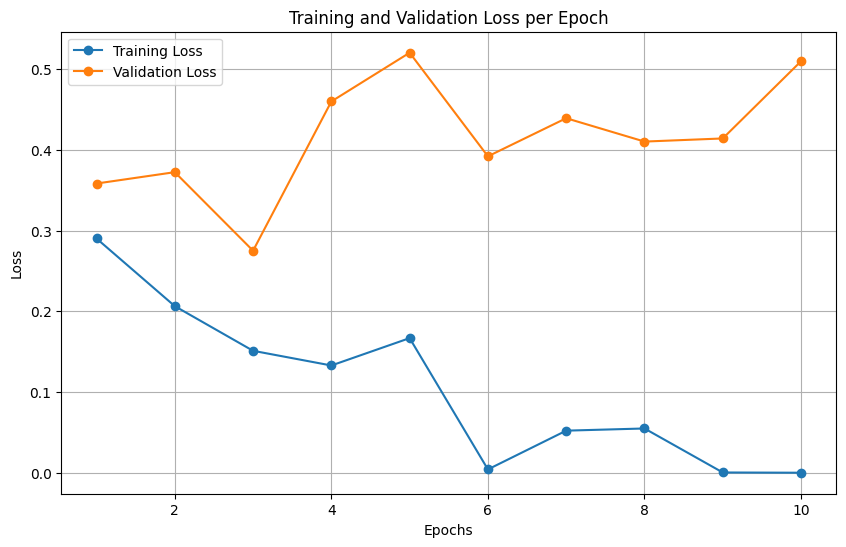

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.9324


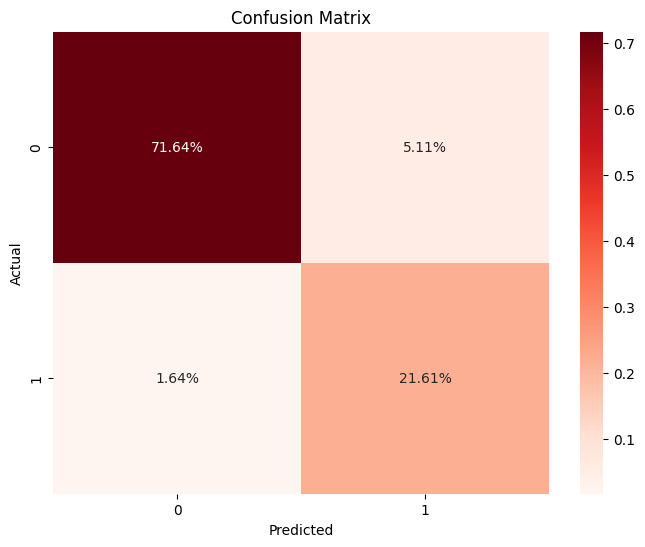

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      1261
         1.0       0.81      0.93      0.86       382

    accuracy                           0.93      1643
   macro avg       0.89      0.93      0.91      1643
weighted avg       0.94      0.93      0.93      1643



In [14]:
log_history = trainer.state.log_history

epoch_train_losses = {}
epoch_eval_losses = {}

for entry in log_history:
    if 'epoch' in entry:
        epoch = int(entry['epoch'])
        if 'loss' in entry:
            epoch_train_losses[epoch] = entry['loss']
        if 'eval_loss' in entry:
            epoch_eval_losses[epoch] = entry['eval_loss']

common_epochs = sorted(set(epoch_train_losses.keys()) & set(epoch_eval_losses.keys()))
final_train_losses = [epoch_train_losses[e] for e in common_epochs]
final_eval_losses = [epoch_eval_losses[e] for e in common_epochs]

for epoch, (train_loss, eval_loss) in enumerate(zip(final_train_losses, final_eval_losses), start=1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {eval_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(common_epochs, final_train_losses, label="Training Loss", marker="o")
plt.plot(common_epochs, final_eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

test_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, predicted_labels))